# Guassian mixture intra-song clustering for identification of "main" beats

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

We default to 95% confidence but I think this might be too strict.

In [2]:
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt

## Test on some generated data sets

Generate a single 2d normal distribution

(1000, 2)


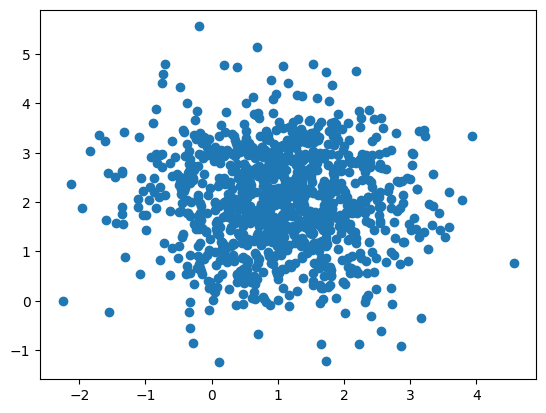

In [3]:
x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


[[1.03272211 2.00929386]] [[[ 1.02883167 -0.03322641]
  [-0.03322641  1.06872405]]]
1.0480616206739206
Num covered: 0.911, valid covered: 0.911, overlapped: 0.0


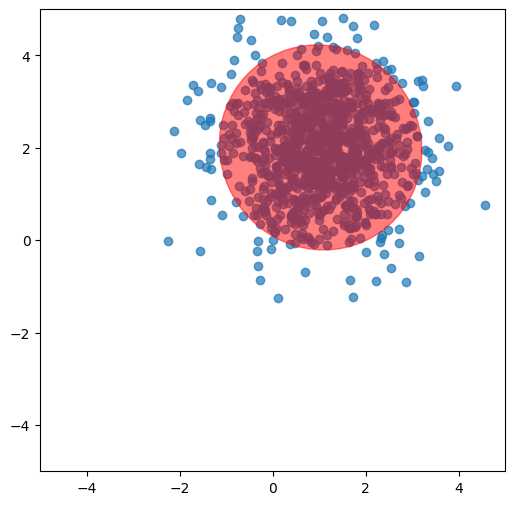

In [4]:
gm = GaussianMixture(n_components=1)


gm.fit(data)

print(gm.means_, gm.covariances_)

#bgm = BayesianGaussianMixture(n_components=2)
#bgm.fit(data)
#print(bgm.means_.shape)

patches, coverage = get_patches(gm, 0.9, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]

print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")



plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

My conclusion from the below is that the patches "contains points" is buggy as shit.  (Note: comment out the set_axlim to fix at least one bug.)

In [5]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data, confidence=0.90))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


89
1000
patch way: 0
my way: 951


1.0480616206739206


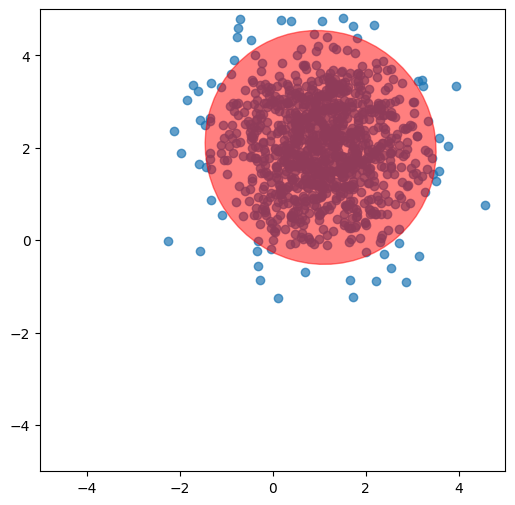

In [8]:
gm = winnow_gm_components(data)
patches, _ = get_patches(gm, 0.95, data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(500, 2)


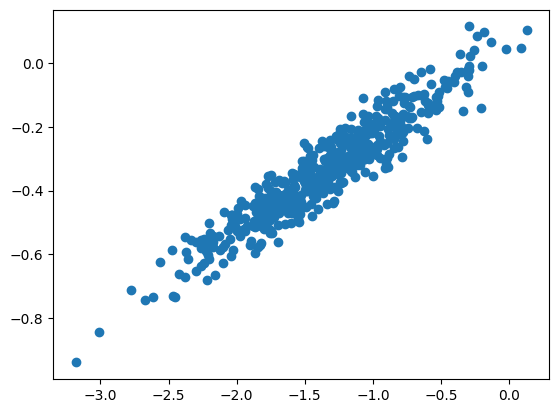

In [9]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
u, s, vh = np.linalg.svd(a)
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = x2
y = y2


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)

[[-1.35377472 -0.33723537]] [[[0.28573712 0.08340736]
  [0.08340736 0.02717474]]]
0.028426104557252335
0.954


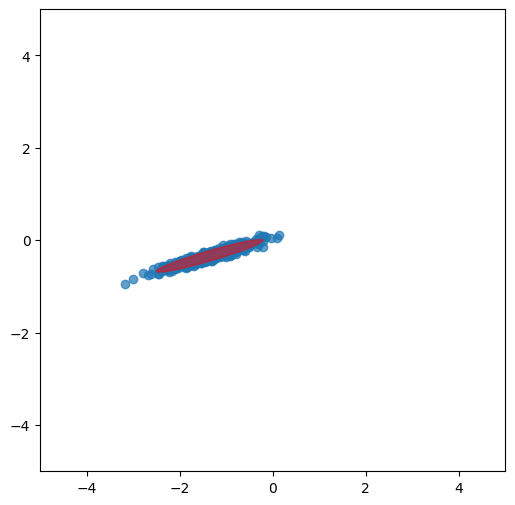

In [10]:
gm = GaussianMixture(n_components=1)
gm.fit(data)
print(gm.means_, gm.covariances_)

patches, coverage = get_patches(gm, 0.9, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


p = patches[0]

print(f"{ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()/data.shape[0]}")


(1500, 2)


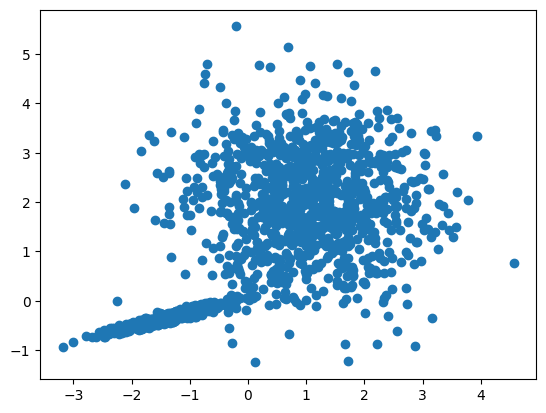

In [11]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[-1.35158857 -0.33626691]
 [ 1.03480843  2.01193814]] [[[ 0.28977598  0.08456674]
  [ 0.08456674  0.02754831]]

 [[ 1.02542881 -0.03770597]
  [-0.03770597  1.06485449]]]
0.02883235248962576
1.0442752174690522


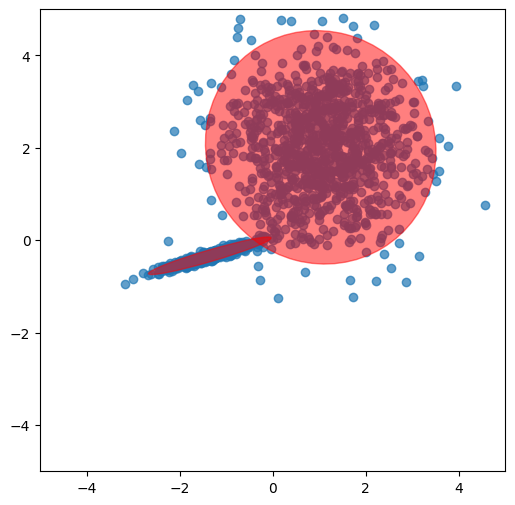

In [12]:
gm = GaussianMixture(n_components=2)
gm.fit(data)
print(gm.means_, gm.covariances_)


# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In case we have overlap, the "center" gets shifted a bit.  Not sure if this is desirable or not.

1.555161009028738


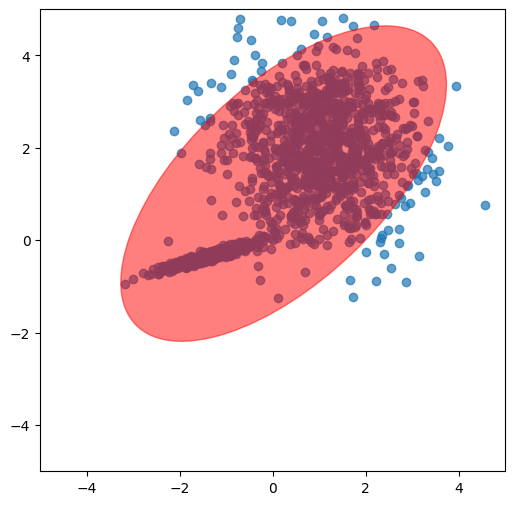

In [14]:
gm = winnow_gm_components(data)


patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


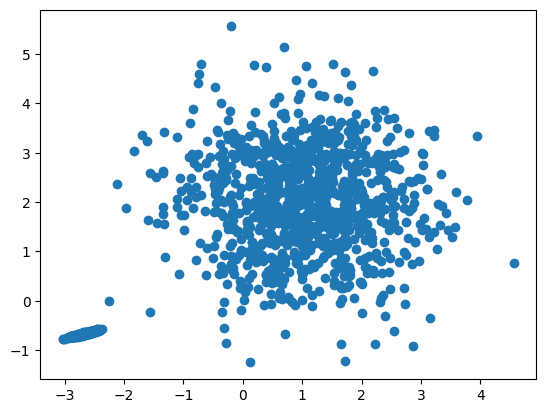

In [15]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



1.048064511588581
0.0011393578012557604
2


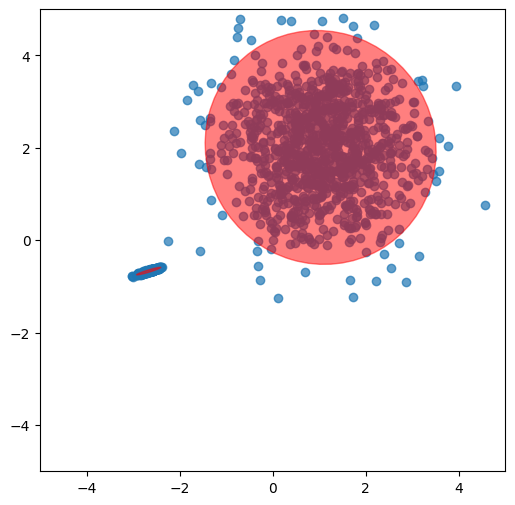

In [18]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


gm = winnow_gm_components(data)
print(gm.means_.shape[0])

### Dumb bug

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


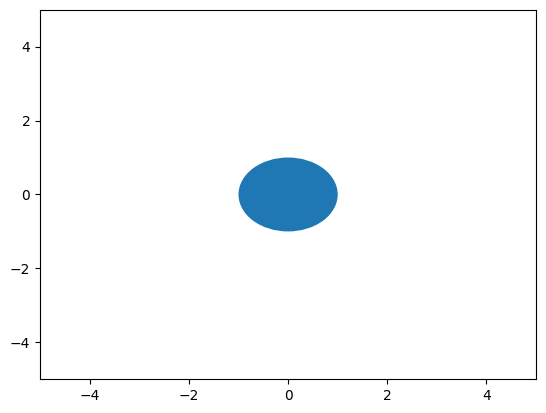

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

## Apply to beat data

### Get measure data

In [20]:
def beat_frames_to_toy(frames, len, target_len):
    x = np.zeros(len + ((target_len - len) % target_len))
    x[frames] = 1
    x = x.reshape((target_len, -1))
    x = x.max(axis=1)
    return x

def beat_frames_to_better_toy(frames, len, target_lens):
    outs = []
    for t in target_lens:
        outs.append(beat_frames_to_toy(frames, len, t) /t )
    return np.concatenate(outs)


In [21]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
#from groove.embedding import beat_frames_to_toy
import numpy as np

file = "milaklaw"

raw, proc, sr = get_measures(file, smooth_power)
bf, nf = get_beat_frames(proc, sr, beat_peaks)

In [22]:
frames = np.array([4,4,7,9,11])

print(beat_frames_to_toy(frames, 12, 6))
print(beat_frames_to_better_toy(frames, 12, [6, 4, 3, 2]))

[0. 0. 1. 1. 1. 1.]
[0.         0.         0.16666667 0.16666667 0.16666667 0.16666667
 0.         0.25       0.25       0.25       0.         0.33333333
 0.33333333 0.5        0.5       ]


In [23]:
out = []
hashable = []
for i in range(len(bf)):
    a = beat_frames_to_better_toy(bf[i], nf[i], [24, 12, 8, 6, 4, 2])
    out.append(a)
    hashable.append(tuple(a.tolist()))

data = np.stack(out)
data.shape


(179, 56)

In [24]:
import collections
counter = collections.Counter(hashable)

print(counter.values())
md = counter.most_common(3)
print(hashable.index(md[0][0]), hashable.index(md[1][0]), hashable.index(md[2][0]))



dict_values([17, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 14, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 9, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
0 23 125


In [25]:
beat_frames_to_toy(bf[20], nf[20], 12)

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])

[1.37094877 1.31549518]
0.002842372879615569
0.00427350153541626


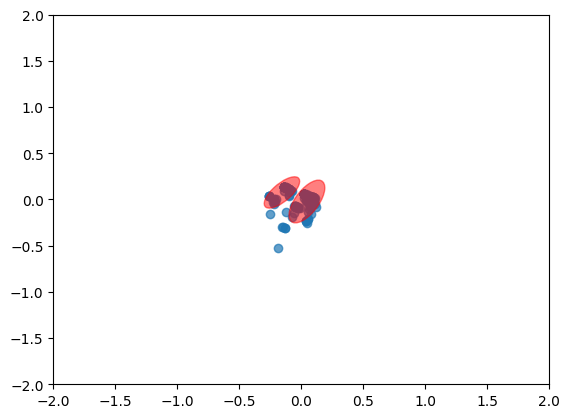

In [26]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
gm = GaussianMixture(n_components=2)


pca.fit(data)

print(pca.singular_values_)
red_data = pca.transform(data)

gm.fit(red_data)

patches, coverage = get_patches(gm, 0.95, red_data)

plt.figure()
ax = plt.gca()
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])



plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)


#gm.fit(data)
#gm.means_.round()

Some rules for choosing the number of components:
1) If there are overlaps between the 95%ile circles, we should reduce.
2) If any circles don't cover 10%, we reduce.

So, start with more, then reduce.

In [27]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

gm = winnow_gm_components(data)

print(gm)
gm.means_

GaussianMixture(n_components=3)


array([[0.03436426, 0.01073883, 0.00085911, 0.        , 0.        ,
        0.        , 0.03608247, 0.00257732, 0.00171821, 0.02319588,
        0.02233677, 0.00687285, 0.02706186, 0.00386598, 0.        ,
        0.03178694, 0.00945017, 0.00214777, 0.03608247, 0.00343643,
        0.00171821, 0.03178694, 0.00300687, 0.00085911, 0.08075601,
        0.00171821, 0.        , 0.07302405, 0.04810997, 0.05670103,
        0.05841924, 0.06357388, 0.02319588, 0.07216495, 0.0652921 ,
        0.00687285, 0.12113402, 0.        , 0.11082474, 0.125     ,
        0.08762887, 0.10953608, 0.10953608, 0.10180412, 0.16151203,
        0.14604811, 0.16666667, 0.15635739, 0.15292096, 0.13917526,
        0.24226804, 0.25      , 0.2371134 , 0.24226804, 0.5       ,
        0.49484536],
       [0.03556911, 0.00203252, 0.        , 0.0304878 , 0.01321138,
        0.01219512, 0.03252033, 0.00203252, 0.00101626, 0.02743902,
        0.01422764, 0.00711382, 0.03556911, 0.00609756, 0.00101626,
        0.0304878 , 0.01829

(3, 56) (179, 56)
[ 32  30 116]


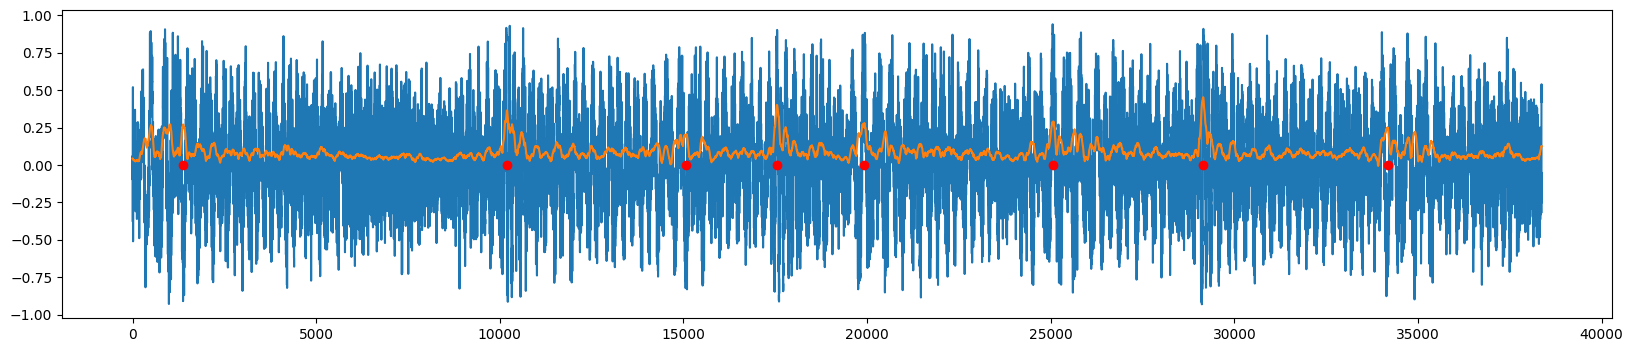

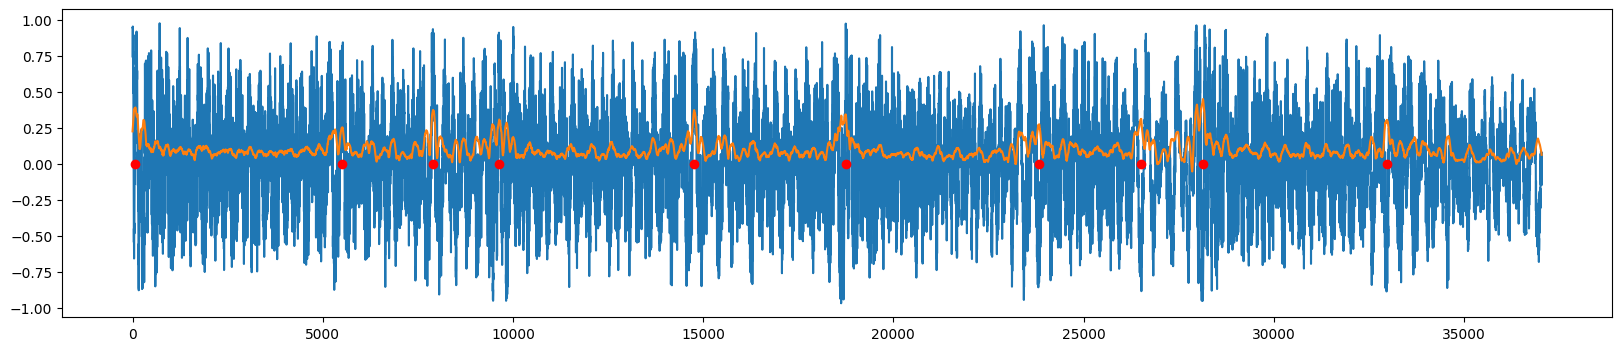

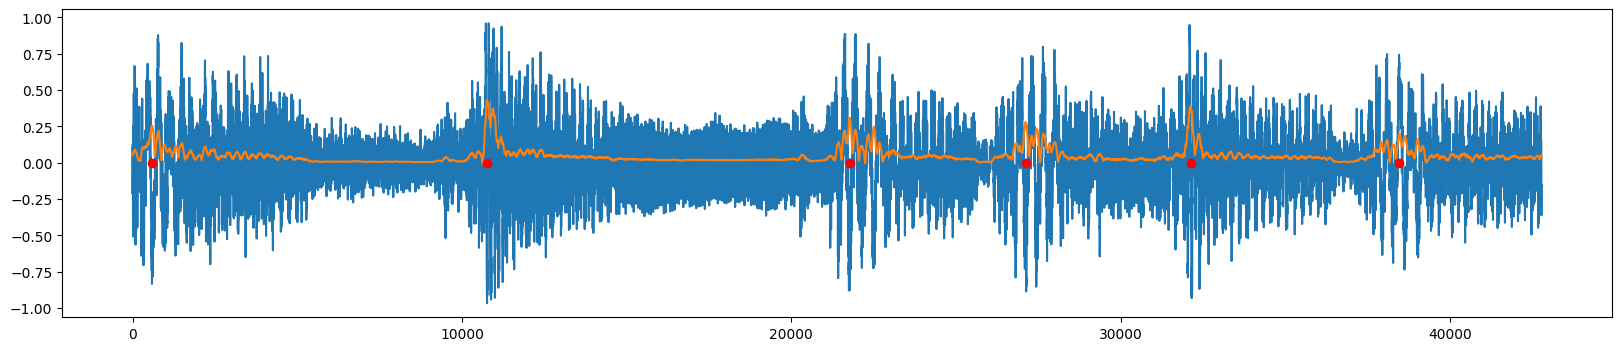

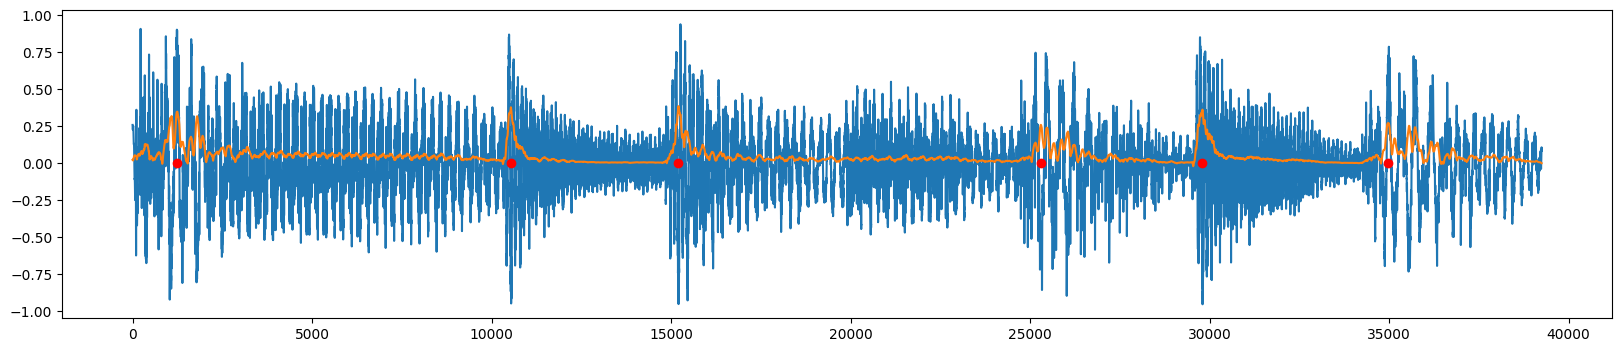

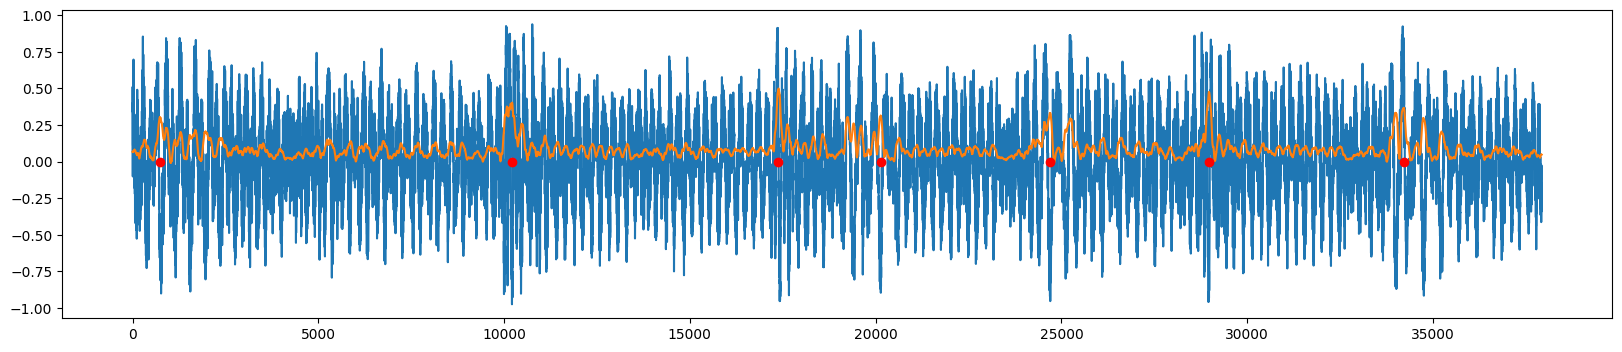

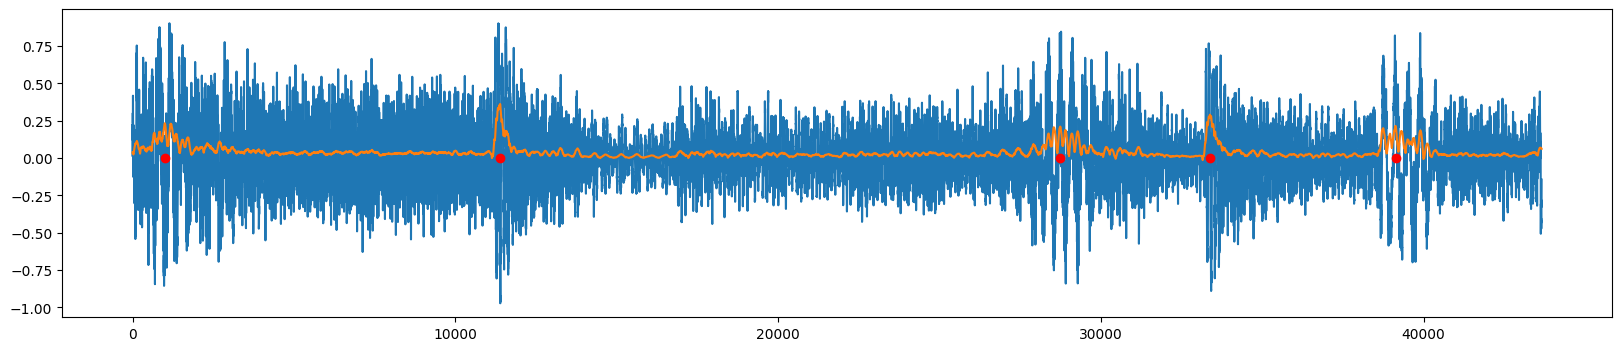

In [28]:
from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa

def find_closest_indices(means, data):
    outs = []
    for i in range(means.shape[0]):
        distances = np.linalg.norm(means[i] - data, axis=1)
        outs.append(distances.argmin(keepdims=True)[0])
    return np.stack(outs)

print(gm.means_.shape, data.shape)

inds = find_closest_indices(gm.means_, data)
data[inds]
print(inds)

inds = np.append(inds, np.array([0, 23, 125]))

raw_measures, proc_measures, sr = get_measures(file, smooth_power)
for i in inds:
    raw, proc = raw_measures[i], proc_measures[i]
    beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
    clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


    plt.figure(figsize=(20, 4))
    plt.plot(raw)
    plt.plot(proc)
    plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
    #display(Audio(data=raw, rate=sr))
    display(Audio(data=raw + clicks, rate=sr))


In [29]:
print(gm.means_[0] - gm.means_[1])
print(np.linalg.norm(gm.covariances_[0]))

gm.means_

[-1.20484452e-03  8.70631129e-03  8.59106529e-04 -3.04878049e-02
 -1.32113821e-02 -1.21951220e-02  3.56214902e-03  5.44799262e-04
  7.01952896e-04 -4.24314810e-03  8.10912748e-03 -2.40968905e-04
 -8.50725002e-03 -2.23158159e-03 -1.01626016e-03  1.29913670e-03
 -8.84251111e-03 -8.01483530e-03  3.56214902e-03 -1.64487470e-03
 -1.33056743e-03 -3.78216411e-03 -2.07442796e-03  8.59106529e-04
  7.58528204e-03 -5.92573967e-02 -4.67479675e-02  5.95088425e-03
 -8.80060347e-03  1.60506244e-02 -1.67840080e-02  5.65753080e-04
 -2.35520912e-02  1.02673707e-03 -9.91115581e-03 -3.28974939e-03
  1.13779231e-02 -1.25000000e-01  7.16620568e-03  0.00000000e+00
 -2.51760121e-02 -3.26879557e-03 -2.20015087e-04 -1.10007543e-02
 -5.15463918e-03 -1.24884754e-02 -3.05311332e-16 -1.03092784e-02
 -5.61562317e-03 -1.12312463e-02 -7.73195876e-03  0.00000000e+00
 -1.28865979e-02 -7.73195876e-03  0.00000000e+00 -5.15463918e-03]
0.019024339301271537


array([[0.03436426, 0.01073883, 0.00085911, 0.        , 0.        ,
        0.        , 0.03608247, 0.00257732, 0.00171821, 0.02319588,
        0.02233677, 0.00687285, 0.02706186, 0.00386598, 0.        ,
        0.03178694, 0.00945017, 0.00214777, 0.03608247, 0.00343643,
        0.00171821, 0.03178694, 0.00300687, 0.00085911, 0.08075601,
        0.00171821, 0.        , 0.07302405, 0.04810997, 0.05670103,
        0.05841924, 0.06357388, 0.02319588, 0.07216495, 0.0652921 ,
        0.00687285, 0.12113402, 0.        , 0.11082474, 0.125     ,
        0.08762887, 0.10953608, 0.10953608, 0.10180412, 0.16151203,
        0.14604811, 0.16666667, 0.15635739, 0.15292096, 0.13917526,
        0.24226804, 0.25      , 0.2371134 , 0.24226804, 0.5       ,
        0.49484536],
       [0.03556911, 0.00203252, 0.        , 0.0304878 , 0.01321138,
        0.01219512, 0.03252033, 0.00203252, 0.00101626, 0.02743902,
        0.01422764, 0.00711382, 0.03556911, 0.00609756, 0.00101626,
        0.0304878 , 0.01829

My dumb toy embedding magnifies small differences.

In [30]:
print((data[inds[0]] - data[inds[2]])[:24])
print((data[inds[0]] - data[inds[2]])[24:24+12])
print((data[inds[0]] - data[inds[2]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[2]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[2]])[24+12+8+4:24+12+8+4+2])

u = data[inds[0]] - data[inds[2]]
print(np.linalg.norm(u))
print(u)

print((data[inds[0]] - data[inds[1]]))
print((data[inds[0]] - data[inds[1]])[:24])
print(np.linalg.norm(data[inds[0]] - data[inds[1]]))


get_beat_frames([proc_measures[79], proc_measures[23]], sr, beat_peaks)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04166667 0.04166667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.08333333 0.08333333
 0.         0.         0.         0.         0.         0.        ]
[0.    0.    0.    0.125 0.    0.    0.    0.   ]
[0.         0.         0.16666667 0.        ]
[0. 0.]
0.2465033242958173
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04166667 0.04166667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08333333 0.08333333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.125      0.         0.
 0.         0.         0.         0.         0.16666667 0.
 0.         0.   

([array([  667,  9935, 17165, 19980, 25304, 28925, 33625]),
  array([  738, 10217, 17385, 20138, 24690, 28971, 34209])],
 [37926, 37926])

In [31]:
print((data[inds[0]] - data[inds[1]])[:24])
print((data[inds[0]] - data[inds[1]])[24:24+12])
print((data[inds[0]] - data[inds[1]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[1]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[1]])[24+12+8+4:24+12+8+4+2])


[ 0.          0.          0.         -0.04166667  0.         -0.04166667
  0.          0.          0.          0.          0.04166667  0.
  0.          0.          0.          0.          0.         -0.04166667
  0.          0.          0.          0.          0.          0.        ]
[ 0.         -0.08333333 -0.08333333  0.          0.          0.08333333
  0.          0.         -0.08333333  0.          0.          0.        ]
[ 0.    -0.125  0.     0.     0.     0.     0.     0.   ]
[0. 0. 0. 0.]
[0. 0.]
